# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.4669857  -1.5         0.          0.
 -6.83172083  6.          0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 5. Import libaries

In [5]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

### 6. The Model

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=512, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.bn2(self.fc2(x)))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=512, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.bn1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 7. The Agent

In [7]:
BUFFER_SIZE = int(1e6)  # replay buffer size int(1e5)
BATCH_SIZE = 512        # minibatch size 128
GAMMA = 0.99            # discount factor
TAU = 1e-1              # for soft update of target parameters 1e-1 
LR_ACTOR = 1e-4         # learning rate of the actor 1e-4
LR_CRITIC = 1e-3        # learning rate of the critic 1e-3
WEIGHT_DECAY = 0        # L2 weight decay 0
UPDATE_EVERY = 4        # how often to update the network 4
UPDATE_STEPS = 1        # how many times to update the network in a row 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        # self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # Learn, if enough samples are available in memory
            if len(self.memory) > BATCH_SIZE:
                for _ in range(UPDATE_STEPS):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().view(1,-1).to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            #action += self.noise.sample()
            action += np.random.normal(0, 0.2, self.action_size)
        return np.clip(action, -1, 1)

    #def reset(self):
        #self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

# class OUNoise:
#     """Ornstein-Uhlenbeck process."""

#     def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
#         """Initialize parameters and noise process."""
#         self.mu = mu * np.ones(size)
#         self.theta = theta
#         self.sigma = sigma
#         self.seed = random.seed(seed)
#         self.reset()

#     def reset(self):
#         """Reset the internal state (= noise) to mean (mu)."""
#         self.state = copy.copy(self.mu)

#     def sample(self):
#         """Update internal state and return it as a noise sample."""
#         x = self.state
#         dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
#         self.state = x + dx
#         return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 8. The DDPG Algorithm

Episode 100	Average Score: 0.03	Score: 0.09	Average Timesteps: 19.20	Timesteps: 30
Episode 200	Average Score: 0.15	Score: 0.00	Average Timesteps: 63.03	Timesteps: 141
Episode 247	Average Score: 0.51	Score: 2.60	Average Timesteps: 198.47	Timesteps: 1000
Environment solved in 247 episodes!	Average Score: 0.51
Episode 300	Average Score: 0.78	Score: 0.40	Average Timesteps: 303.66	Timesteps: 1610
Episode 400	Average Score: 1.10	Score: 1.59	Average Timesteps: 425.02	Timesteps: 5960
Episode 500	Average Score: 1.47	Score: 0.40	Average Timesteps: 563.45	Timesteps: 1490


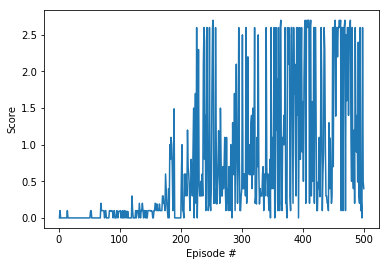

In [8]:
def ddpg(n_episodes=1000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    timesteps_deque = deque(maxlen=print_every)
    scores = []
    solved = 0
    for i_episode in range(1, n_episodes+1):
        # state = env.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        state_agent0 = states[0]
        state_agent1 = states[1]
        #agent.reset()
        score_agent0 = 0
        score_agent1 = 0
        timesteps = 0
        for t in range(max_t): 
            action_agent0 = agent.act(state_agent0)
            action_agent1 = agent.act(state_agent1)
            # next_state, reward, done, _ = env.step(action)
            action = np.concatenate([action_agent0, action_agent1])
            env_info = env.step(action)[brain_name]
            states = env_info.vector_observations
            next_state_agent0 = states[0]
            next_state_agent1 = states[1]
            #print('next_state: ', next_state)
            rewards = env_info.rewards
            reward_agent0 = rewards[0]
            reward_agent1 = rewards[1]
            #print('reward: ', reward)
            dones = env_info.local_done
            done_agent0 = dones[0]
            done_agent1 = dones[1]
            #print('done: ', done)
            agent.step(state_agent0, action_agent0, reward_agent0, next_state_agent0, done_agent0)
            agent.step(state_agent1, action_agent1, reward_agent1, next_state_agent1, done_agent1)
            state_agent0 = next_state_agent0
            state_agent1 = next_state_agent1
            score_agent0 += reward_agent0
            score_agent1 += reward_agent1
            timesteps += 1
            if np.any(dones):
                break 
        score = max(score_agent0, score_agent1)
        scores_deque.append(score)
        scores.append(score)
        timesteps_deque.append(timesteps)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tAverage Timesteps: {:.2f}\tTimesteps: {}'.format(i_episode, np.mean(scores_deque), score, np.mean(timesteps_deque), timesteps), end="")
        #torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        #torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tAverage Timesteps: {:.2f}\tTimesteps: {}'.format(i_episode, np.mean(scores_deque), score, np.mean(timesteps_deque), timesteps))
        if (np.mean(scores_deque)>=0.5) and (solved == 0):
            solved = 1
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    return scores

agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)
scores = ddpg(n_episodes=500)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 9. The history of my tries 
Starting with the initial configuration, the code from the [implementation](https://github.com/fjonck/Project_2_Continuous-Control) of the continuous control project, which uses a DDPG approach to solve the [OpenAI Gym's Tennis environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#tennis).

Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.01
Episode 500	Average Score: 0.00
Episode 600	Average Score: 0.02
Episode 700	Average Score: 0.00
Episode 800	Average Score: 0.00
Episode 900	Average Score: 0.00
Episode 1000	Average Score: 0.00
Episode 1100	Average Score: 0.00
Episode 1200	Average Score: 0.04
Episode 1300	Average Score: 0.03
Episode 1400	Average Score: 0.03
Episode 1500	Average Score: 0.02
Episode 1600	Average Score: 0.04
Episode 1700	Average Score: 0.06
Episode 1800	Average Score: 0.08
Episode 1900	Average Score: 0.10
Episode 2000	Average Score: 0.19
Episode 2100	Average Score: 0.50
Episode 2200	Average Score: 0.30
Episode 2278	Average Score: 1.75

Network: 256, 128. LR_CRITIC = 1e-4:
Episode 100	Average Score: 0.02	Timesteps played: 13
Episode 200	Average Score: 0.00	Timesteps played: 13
Episode 300	Average Score: 0.00	Timesteps played: 13
Episode 400	Average Score: 0.00	Timesteps played: 13
Episode 500	Average Score: 0.00	Timesteps played: 13
Episode 600	Average Score: 0.00	Timesteps played: 13
Episode 700	Average Score: 0.00	Timesteps played: 13
Episode 800	Average Score: 0.01	Timesteps played: 13
Episode 900	Average Score: 0.00	Timesteps played: 13
Episode 1000	Average Score: 0.00	Timesteps played: 13
Episode 1100	Average Score: 0.01	Timesteps played: 12
Episode 1200	Average Score: 0.01	Timesteps played: 31
Episode 1300	Average Score: 0.04	Timesteps played: 14
Episode 1400	Average Score: 0.07	Timesteps played: 30
Episode 1500	Average Score: 0.08	Timesteps played: 27
Episode 1600	Average Score: 0.09	Timesteps played: 30
Episode 1700	Average Score: 0.12	Timesteps played: 562
Episode 1800	Average Score: 0.14	Timesteps played: 306
Episode 1900	Average Score: 0.10	Timesteps played: 32
Episode 2000	Average Score: 0.11	Timesteps played: 339
Episode 2100	Average Score: 0.17	Timesteps played: 542
Episode 2200	Average Score: 0.38	Timesteps played: 180
Episode 2230	Average Score: 0.51	Timesteps played: 640
Environment solved in 2230 episodes!	Average Score: 0.51

Network: 512, 256. max_t=1000

BUFFER_SIZE = int(1e6)  # replay buffer size int(1e5)
BATCH_SIZE = 512        # minibatch size 128
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 1e-4
LR_CRITIC = 1e-3        # learning rate of the critic 1e-3
WEIGHT_DECAY = 0        # L2 weight decay 0
UPDATE_EVERY = 4        # how often to update the network 4
UPDATE_STEPS = 1        # how many times to update the network in a row 1

Episode 100	Average Score: 0.00	Score: 0.00	Timesteps played: 13
Episode 200	Average Score: 0.01	Score: 0.00	Timesteps played: 13
Episode 300	Average Score: 0.00	Score: 0.00	Timesteps played: 13
Episode 400	Average Score: 0.00	Score: 0.00	Timesteps played: 13
Episode 500	Average Score: 0.00	Score: 0.00	Timesteps played: 13
Episode 600	Average Score: 0.01	Score: 0.09	Timesteps played: 29
Episode 700	Average Score: 0.04	Score: 0.00	Timesteps played: 263
Episode 800	Average Score: 0.05	Score: 0.10	Timesteps played: 462
Episode 900	Average Score: 0.18	Score: 0.10	Timesteps played: 550
Episode 990	Average Score: 0.51	Score: 2.70	Timesteps played: 999
Environment solved in 990 episodes!	Average Score: 0.51
Episode 995	Average Score: 0.57	Score: 2.60	Timesteps played: 999

TAU = 1e-1

Episode 100	Average Score: 0.01	Score: 0.00	Timesteps played: 16
Episode 200	Average Score: 0.23	Score: 0.10	Timesteps played: 408
Episode 267	Average Score: 0.52	Score: 2.60	Timesteps played: 999
Environment solved in 267 episodes!	Average Score: 0.52
Episode 271	Average Score: 0.57	Score: 2.60	Timesteps played: 999

TAU = 0.5

Episode 100	Average Score: 0.03	Score: 0.00	Average Timesteps: 21.34	Timesteps: 14
Episode 200	Average Score: 0.09	Score: 0.10	Average Timesteps: 41.71	Timesteps: 544
Episode 300	Average Score: 0.20	Score: 0.20	Average Timesteps: 84.50	Timesteps: 928
Episode 400	Average Score: 0.34	Score: 0.60	Average Timesteps: 139.79	Timesteps: 240
Episode 462	Average Score: 0.51	Score: 2.10	Average Timesteps: 206.02	Timesteps: 8331
Environment solved in 462 episodes!	Average Score: 0.51
Episode 500	Average Score: 0.78	Score: 2.60	Average Timesteps: 306.64	Timesteps: 1001
Episode 600	Average Score: 1.18	Score: 0.20	Average Timesteps: 453.93	Timesteps: 8191
Episode 668	Average Score: 1.28	Score: 2.40	Average Timesteps: 489.70	Timesteps: 9091

TAU = 1e-1, Network: 512, 512. max_t=10000:
Episode 100	Average Score: 0.02	Score: 0.00	Average Timesteps: 20.97	Timesteps: 14
Episode 200	Average Score: 0.11	Score: 0.10	Average Timesteps: 48.92	Timesteps: 518
Episode 300	Average Score: 0.36	Score: 0.00	Average Timesteps: 147.13	Timesteps: 2301
Episode 325	Average Score: 0.51	Score: 2.60	Average Timesteps: 202.61	Timesteps: 1001
Environment solved in 325 episodes!	Average Score: 0.51
Episode 400	Average Score: 1.12	Score: 0.00	Average Timesteps: 436.60	Timesteps: 1421
Episode 500	Average Score: 1.39	Score: 1.20	Average Timesteps: 531.29	Timesteps: 4571
Episode 600	Average Score: 1.68	Score: 0.79	Average Timesteps: 641.33	Timesteps: 3181
Episode 687	Average Score: 1.73	Score: 2.70	Average Timesteps: 659.01	Timesteps: 1001

Network: 512, 256. max_t=1000:
Episode 100	Average Score: 0.02	Score: 0.00	Average Timesteps: 17.52	Timesteps: 14
Episode 200	Average Score: 0.07	Score: 0.09	Average Timesteps: 28.05	Timesteps: 311
Episode 300	Average Score: 0.09	Score: 0.10	Average Timesteps: 37.17	Timesteps: 517
Episode 400	Average Score: 0.24	Score: 0.00	Average Timesteps: 98.25	Timesteps: 200
Episode 493	Average Score: 0.51	Score: 1.80	Average Timesteps: 201.82	Timesteps: 6890
Environment solved in 493 episodes!	Average Score: 0.51
Episode 500	Average Score: 0.56	Score: 0.90	Average Timesteps: 218.46	Timesteps: 358
Episode 600	Average Score: 1.49	Score: 2.70	Average Timesteps: 569.38	Timesteps: 1000
Episode 640	Average Score: 1.61	Score: 0.70	Average Timesteps: 621.01	Timesteps: 2740

Episode 100	Average Score: 0.02	Score: 0.09	Average Timesteps: 17.96	Timesteps: 30
Episode 200	Average Score: 0.05	Score: 0.00	Average Timesteps: 26.71	Timesteps: 18
Episode 300	Average Score: 0.13	Score: 0.20	Average Timesteps: 51.02	Timesteps: 919
Episode 381	Average Score: 0.51	Score: 1.40	Average Timesteps: 201.08	Timesteps: 5500
Environment solved in 381 episodes!	Average Score: 0.51
Episode 385	Average Score: 0.55	Score: 0.50	Average Timesteps: 215.26	Timesteps: 1890

Network: 512, 512, LR_CRITIC = 1e-4:

Episode 100	Average Score: 0.02	Score: 0.00	Average Timesteps: 20.09	Timesteps: 14
Episode 200	Average Score: 0.04	Score: 0.00	Average Timesteps: 23.59	Timesteps: 147
Episode 300	Average Score: 0.12	Score: 0.20	Average Timesteps: 50.35	Timesteps: 776
Episode 370	Average Score: 0.51	Score: 2.60	Average Timesteps: 199.72	Timesteps: 1000
Environment solved in 370 episodes!	Average Score: 0.51
Episode 400	Average Score: 0.99	Score: 2.60	Average Timesteps: 379.94	Timesteps: 1000

Network: 512, 256, LR_CRITIC = 1e-4, max_t=1000:

Episode 100	Average Score: 0.02	Score: 0.10	Average Timesteps: 18.67	Timesteps: 41
Episode 200	Average Score: 0.34	Score: 0.20	Average Timesteps: 129.63	Timesteps: 9100
Episode 227	Average Score: 0.51	Score: 2.70	Average Timesteps: 197.99	Timesteps: 1000
Environment solved in 227 episodes!	Average Score: 0.51
Episode 299	Average Score: 1.34	Score: 2.60	Average Timesteps: 515.75	Timesteps: 1000